In [1]:
%load_ext autotime

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

time: 578 ms


In [3]:
np.random.seed(23)

time: 615 µs


# Import data

In [4]:
train_pdf = pd.read_csv('../data/train.csv')
test_pdf = pd.read_csv('../data/test.csv')

time: 303 ms


In [5]:
train_pdf['date'] = pd.to_datetime(train_pdf['date'], format="%Y-%m-%d")

time: 113 ms


In [6]:
train_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
time: 11.2 ms


In [7]:
train_pdf.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


time: 13.8 ms


In [8]:
train_random_sample_store_item_pdf = train_pdf[['store','item']].drop_duplicates().reset_index(drop=True).sample(n=3, random_state=23)
train_random_sample_store_item_pdf.head()

,store,item
94,5,10
390,1,40
178,9,18


time: 39.1 ms


In [9]:
train_sample_pdf = train_pdf.merge(train_random_sample_store_item_pdf, on=['store','item'])
train_sample_pdf.head()

,date,store,item,sales
0,2013-01-01,5,10,31
1,2013-01-02,5,10,28
2,2013-01-03,5,10,23
3,2013-01-04,5,10,32
4,2013-01-05,5,10,30


time: 42.6 ms


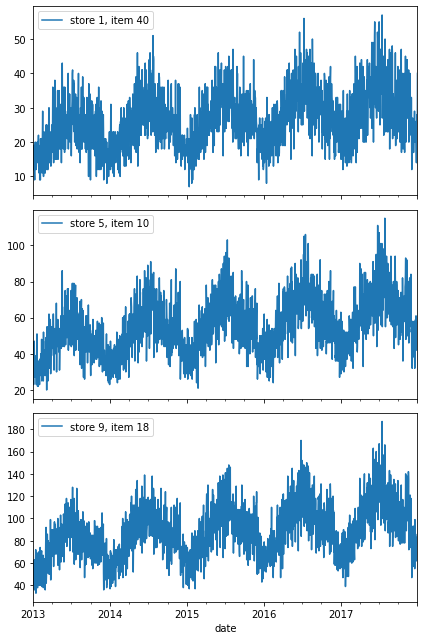

time: 1.37 s


In [10]:
train_sample_groupby_pdf = train_sample_pdf.groupby(['store','item'])
fig, axs = plt.subplots(nrows=len(train_sample_groupby_pdf),ncols=1, figsize=(6,3*len(train_sample_groupby_pdf)),
                        sharex=True)
for ax, (name, group) in zip(axs.ravel(), train_sample_groupby_pdf):
    label = f"store {name[0]}, item {name[1]}"
    group.plot(x='date', y='sales', ax=ax, label=label)
plt.tight_layout()

# Cyclical time feautures

see https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/  

In [11]:
def sin_transform(values, n_values_in_cycle):
    return np.sin((2 * np.pi * values) / (n_values_in_cycle))

def cos_transform(values, n_values_in_cycle):
    return np.cos(2 * np.pi * values / (n_values_in_cycle))

def add_time_features(pdf, date_column='date'):
    pdf = pdf.sort_values(by=[date_column], ascending=True)
    pdf['dayofweek'] = pdf[date_column].dt.dayofweek
    pdf['month'] = pdf[date_column].dt.month
    pdf['day'] = pdf[date_column].dt.day
    return pdf

def add_cyclical_features(pdf):
    assert 'dayofweek' in pdf.columns 
    assert 'month' in pdf.columns 
    assert 'day' in pdf.columns 
    for k,v in {'dayofweek':7,'month':12,'day':31}.items():
        pdf["cos_"+k] = cos_transform(pdf[k].values, v)
        pdf["sin_"+k] = sin_transform(pdf[k].values, v)   
    return pdf 


time: 2.63 ms


In [12]:
store_9_item_18_pdf = train_pdf.query("store==9 & item==18")
store_9_item_18_pdf = add_time_features(store_9_item_18_pdf)
store_9_item_18_pdf = add_cyclical_features(store_9_item_18_pdf)
store_9_item_18_pdf.head()

,date,store,item,sales,dayofweek,month,day,cos_dayofweek,sin_dayofweek,cos_month,sin_month,cos_day,sin_day
325028,2013-01-01,9,18,41,1,1,1,0.623490,0.781831,0.866025,0.5,0.979530,0.201299
325029,2013-01-02,9,18,51,2,1,2,-0.222521,0.974928,0.866025,0.5,0.918958,0.394356
325030,2013-01-03,9,18,52,3,1,3,-0.900969,0.433884,0.866025,0.5,0.820763,0.571268
325031,2013-01-04,9,18,60,4,1,4,-0.900969,-0.433884,0.866025,0.5,0.688967,0.724793
325032,2013-01-05,9,18,47,5,1,5,-0.222521,-0.974928,0.866025,0.5,0.528964,0.848644


time: 24.6 ms


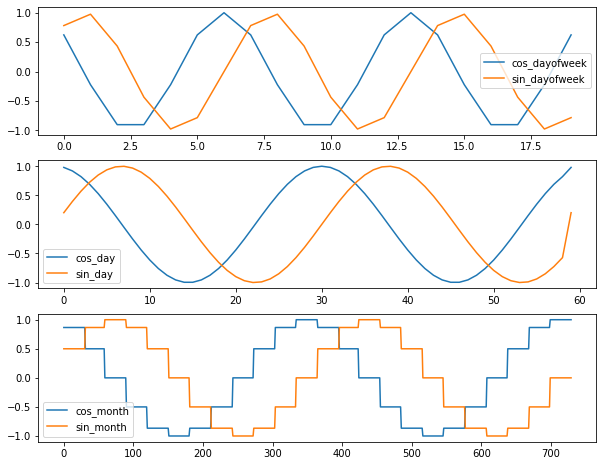

time: 689 ms


In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10,8))
store_9_item_18_pdf['cos_dayofweek'].head(20).reset_index(drop=True).plot(ax=ax1)
store_9_item_18_pdf['sin_dayofweek'].head(20).reset_index(drop=True).plot(ax=ax1)
ax1.legend()
store_9_item_18_pdf['cos_day'].head(int(2*30)).reset_index(drop=True).plot(ax=ax2)
store_9_item_18_pdf['sin_day'].head(int(2*30)).reset_index(drop=True).plot(ax=ax2)
ax2.legend()
store_9_item_18_pdf['cos_month'].head(int(2*365)).reset_index(drop=True).plot(ax=ax3)
store_9_item_18_pdf['sin_month'].head(int(2*365)).reset_index(drop=True).plot(ax=ax3)
ax3.legend();

# Create sequences

In [14]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem,
                                                                              100 * (start_mem - end_mem) / start_mem))
    return df

time: 3.33 ms


In [15]:
def applyParallel(dfGrouped, func, n_jobs=multiprocessing.cpu_count()):
    retLst = Parallel(n_jobs=n_jobs)(delayed(func)(group) for name, group in tqdm(dfGrouped))
    return pd.concat(retLst)

time: 979 µs


In [16]:
def create_sequence_wrapper_pdf(train_sequence_length = int(365 + np.floor(365/2)), predict_sequence_length = 90, min_step=5,
            max_step=15,
            numerical_features = ['sales','cos_dayofweek','sin_dayofweek','cos_month','sin_month','cos_day','sin_day'], 
            categorical_features = ['store','item']):
    def create_sequence_pdf(pdf):
        item = pdf.iloc[0]['item']
        store = pdf.iloc[0]['store']
        pdf = add_time_features(pdf)
        pdf = add_cyclical_features(pdf)
        idx = 0
        train_seq = []
        target_seq = []
        store_list = []
        item_list = []
        step_list = []
        step = np.random.randint(min_step,max_step+1)
        while True:
            train_part_pdf = pdf.iloc[0+idx:train_sequence_length+idx]
            target_part_pdf = pdf.iloc[train_sequence_length+idx:train_sequence_length+predict_sequence_length+idx]
            if train_part_pdf.shape[0]!=train_sequence_length or target_part_pdf.shape[0]!=predict_sequence_length:
                break
            mu_ = train_part_pdf['sales'].mean()
            std_ = train_part_pdf['sales'].std()
            train_part_pdf['sales']= (train_part_pdf['sales']-mu_)/std_
            target_part_pdf['sales']= (target_part_pdf['sales']-mu_)/std_
            train_seq.append(train_part_pdf[numerical_features].values)
            target_seq.append(target_part_pdf[numerical_features].values)
            store_list.append(item)
            item_list.append(item)
            step_list.append(step)
            idx += step
        return pd.DataFrame({'train_seq':train_seq,'target_seq':target_seq,'store':store_list,'item':item_list,'step':step_list})
    return create_sequence_pdf


time: 2.81 ms


In [17]:
create_sequence_func_pdf = create_sequence_wrapper_pdf()

time: 356 µs


In [18]:
store_9_item_18_seq_pdf = applyParallel(train_pdf.query("store==9 & item==18").groupby(['store','item']), create_sequence_func_pdf, 6)

100%|██████████| 1/1 [00:00<00:00, 87.63it/s]
time: 1.06 s


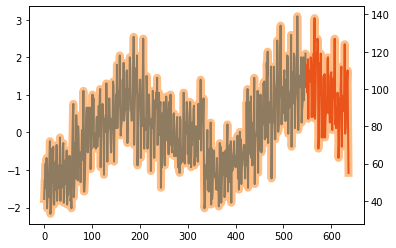

time: 313 ms


In [19]:
fig, ax1 = plt.subplots()
ax1_sec = ax1.twinx()
train_seq_plot = store_9_item_18_seq_pdf['train_seq'].iloc[0][:,0]
x_train_seq_plot = np.arange(train_seq_plot.shape[0])
target_seq_plot = store_9_item_18_seq_pdf['target_seq'].iloc[0][:,0]
x_target_seq_plot = np.arange(target_seq_plot.shape[0])+x_train_seq_plot[-1]+1
ax1.plot(x_train_seq_plot, train_seq_plot, color="C0", lw=2)
ax1.plot(x_target_seq_plot, target_seq_plot, color="C3", lw=2)
ax1_sec.plot(train_pdf.query("store==9 & item==18")['sales'].iloc[0:int(365 + np.floor(365/2))+90].values, color="C1", lw=8, alpha=0.5);

In [20]:
features_pdf = applyParallel(train_pdf.groupby(['store','item']), create_sequence_func_pdf, 6)

100%|██████████| 500/500 [00:59<00:00,  8.42it/s]
time: 1min 2s


In [21]:
features_reduced_memory_pdf = reduce_mem_usage(features_pdf)

Mem. usage decreased to  1.63 Mb (43.8% reduction)
time: 6.35 ms


In [22]:
features_reduced_memory_pdf.to_pickle("../data/features_reduced_memory_pdf_step5_to_15")

time: 2.89 s


In [23]:
features_reduced_memory_read_pdf = pd.read_pickle("../data/features_reduced_memory_pdf_step5_to_15") 

time: 1.27 s


In [24]:
features_reduced_memory_read_pdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63379 entries, 0 to 108
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   train_seq   63379 non-null  object
 1   target_seq  63379 non-null  object
 2   store       63379 non-null  int8  
 3   item        63379 non-null  int8  
 4   step        63379 non-null  int8  
dtypes: int8(3), object(2)
memory usage: 1.6+ MB
time: 14.5 ms


In [25]:
features_reduced_memory_read_pdf.head()

,train_seq,target_seq,store,item,step
0,"[[-0.7234640813887503, 0.6234898018587336, 0.7...","[[1.2086634719694886, -0.22252093395631434, 0....",1,1,12
1,"[[-1.2931591355122143, 0.6234898018587334, -0....","[[0.6219131062739025, 1.0, 0.0, -0.86602540378...",1,1,12
2,"[[-0.6527691844876597, -0.9009688679024191, -0...","[[1.9688515491008134, -0.2225209339563146, -0....",1,1,12
3,"[[-1.3821883599541458, -0.22252093395631434, 0...","[[0.5288013831166483, -0.900968867902419, 0.43...",1,1,12
4,"[[-1.4252243494639707, 1.0, 0.0, 0.50000000000...","[[-0.5545545715359028, 0.6234898018587336, 0.7...",1,1,12


time: 208 ms


In [28]:
features_reduced_memory_read_pdf['step'].sort_values().unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=int8)

time: 6.35 ms
